# NLP Capstone Project - Movie Review - Sentiment Analysis -  Classify the sentiment of sentences from the Rotten Tomatoes dataset
## Developing Deep Learning Models using GLoVE pretrained word embeddings as feature extraction / representation

![](https://cdn.steemitimages.com/DQmQZCf7ME7Haj3X3MzXtG8R8JtGmTpuh5NXDSd3wKueva7/rottentomatoes.png)

![DL](https://www.doulos.com/images/logos/DeepLearning.jpg)

![W2v](https://newvitruvian.com/images/term-vector-word2vec-4.png)

Moving one from EDA and Machine Leaning models to Deep Learning with the movie review sentiment analysis dataset with Keras. In particular the DL models will be developed in conjunction with the pre-trained Word Embeddings.

The pretrained word embeddings will be downloaded from Stanford NLP GloVe: Global Vectors for Word Representation [source](https://nlp.stanford.edu/projects/glove/).

At first, There must be mention that after EDA an odd conclusion was made. The dataset of this competition turned to have some unique features. we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:

- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

** This thought will be enhanced later with my anomaly detection insights **

## Loading Main Libraries

In [1]:
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import nltk

In [2]:
df = pd.read_csv("../input/train.tsv", sep="\t")

df_test = pd.read_csv("../input/test.tsv", sep="\t")

In [3]:
df.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [4]:
df_test.head(10)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


### Thoughts before training DL models
Here are couple of instances where punctuations appeared to be predictive. So if we "cleanedup" the data in the name of data preparation some predictiveness will be lost.

In [5]:
example = df[(df['PhraseId'] >= 0) & (df['PhraseId'] <= 2)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .  - Sentiment: 1

A series of escapades demonstrating the adage that what is good for the goose  - Sentiment: 2


In [6]:
example = df[(df['PhraseId'] >= 517) & (df['PhraseId'] <= 518)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

As inept as big-screen remakes of The Avengers and The Wild Wild West .  - Sentiment: 1

As inept as big-screen remakes of The Avengers and The Wild Wild West  - Sentiment: 2


Below another example that the appearance punctuation symbol "," is important

In [7]:
example = df[(df['PhraseId'] >= 68) & (df['PhraseId'] <= 69)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

quiet , introspective and entertaining  - Sentiment: 3

quiet  - Sentiment: 2


Below another example that the appearance punctuation symbol "!" is important

In [8]:
example = df[(df['PhraseId'] >= 10737) & (df['PhraseId'] <= 10738)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

Just bring on the Battle Bots , please !  - Sentiment: 3

bring on the Battle Bots , please !  - Sentiment: 2


Another strange thing that I discovered is that there are phrases with a single word only and if they disappear at the following phrases the sentiment changes.

In [9]:
example = df[(df['PhraseId'] >= 22) & (df['PhraseId'] <= 24)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

print()

print(example["Phrase"].values[2], " - Sentiment:", example["Sentiment"].values[2])

good for the goose  - Sentiment: 3

good  - Sentiment: 3

for the goose  - Sentiment: 2


In [10]:
example = df[(df['PhraseId'] >= 46) & (df['PhraseId'] <= 47)]

print(example["Phrase"].values[0], " - Sentiment:", example["Sentiment"].values[0])

print()

print(example["Phrase"].values[1], " - Sentiment:", example["Sentiment"].values[1])

amuses but none of which amounts to much of a story  - Sentiment: 2

amuses  - Sentiment: 3


As you can see sentence id denotes a single review with the phrase column having the entire review text as an input instance followed by random suffixes of the same sentence to form multiple phrases with subsequent phrase ids. This repeats for every single new sentence id (or new review per se). The sentiment is coded with 5 values 0= Very negative to 4=Very positive and everything else in between.

A quick glance will show you that the data is a little weird for a sentiment corpus:

- Phrases of sentences are** chopped up compeltely randomly**. So logic like sentence tokenization based on periods or punctuations or something of that sort doesn't apply
- Certain phrases are **with one single word!**.
- For some phrases inclusion of a punctuation like a comma or a full stop changes the sentiment from say 2 to 3 i.e neutral to positive.
- Some phrases **starts** with a punctuation like a **backquote**.
- Some phrases **end** with a **punctuation**
- There are some ** weird ** words such as ** -RRB-,  -LRB- **

All these weird aspects of this dataset, can be helpful and may be predictive. Afterall, we are looking for patterns in data. Therefore, it would be easier for us to engineer features, I mean apart from the text features that can be extracted from the corpus.

So, after all this train of thought, let us move on to Deep Learning and Predictive Models.

### Helper Functions to tokenize and create a vocabulary
They both will be needed later in Deep Learning functions

In [11]:
def tokenize_the_text(phrases):
    
    from nltk.tokenize import word_tokenize
    from nltk.text import Text
    
    tokens = [word for word in phrases]
    tokens = [word.lower() for word in tokens]
    tokens = [word_tokenize(word) for word in tokens]
    
    return tokens

crude_tokens = tokenize_the_text(df.Phrase)
print(crude_tokens[0:10])

[['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose', 'is', 'also', 'good', 'for', 'the', 'gander', ',', 'some', 'of', 'which', 'occasionally', 'amuses', 'but', 'none', 'of', 'which', 'amounts', 'to', 'much', 'of', 'a', 'story', '.'], ['a', 'series', 'of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['a', 'series'], ['a'], ['series'], ['of', 'escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['of'], ['escapades', 'demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose'], ['escapades'], ['demonstrating', 'the', 'adage', 'that', 'what', 'is', 'good', 'for', 'the', 'goose']]


In [12]:
def create_a_vocab(tokens):
    
    vocab = set()

    for sentence in tokens:
        for word in sentence:
            vocab.add(word)

    vocab = list(vocab)

    return vocab
    
vocab = create_a_vocab(crude_tokens)

print(len(vocab))
#print(type(vocab))
#print(sorted(vocab))

16540


## Deep Learning Techniques

### Load Keras functions

In [13]:
# Keras Libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, GRU, Conv1D, MaxPooling1D, Dropout, SpatialDropout1D, Bidirectional, Activation,GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


Using TensorFlow backend.


## Word to feature Extraction with pre-trained Word Embeddings
![w2v2](https://cdn-images-1.medium.com/max/1600/1*jpnKO5X0Ii8PVdQYFO2z1Q.png)

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Word Embeddings originates from the idea of generating distributed representations. Intuitively, there is some dependence of one word on the other words. The words in context of this word would get a greater share of this dependence. In one hot encoding representations, all the words are independent of each other, as mentioned earlier.

Word Embeddings are vector representations of a particular word. Word Embeddings is a method to construct such an embedding. It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words. [source](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).

To get Word Embeddings they will be downloaded from Stanford NLP GloVe: **Global Vectors for Word Representation**. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space [source](https://nlp.stanford.edu/projects/glove/).

So we continue with the download of the GLoVe embeddings, The embedding size of 300 will be used for increased expressibility.

In [14]:
import os,requests
def download(url):
    get_response = requests.get(url,stream=True)
    file_name  = url.split("/")[-1]
    with open(file_name, 'wb') as f:
        for chunk in get_response.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
        

download("http://nlp.stanford.edu/data/glove.6B.zip")

### Export the GLoVe zip file.

In [15]:
import zipfile
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [16]:
import os
os.listdir()

['glove.6B.zip',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 '__notebook_source__.ipynb',
 '.ipynb_checkpoints']

### Reading the GLoVe embedding txt file

In [17]:
import numpy as np

embedding_dim = 300
filename = 'glove.6B.'+ str(embedding_dim) +'d.txt'

glove_w2v_embeddings_index = dict()
f = open(filename, "r", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_w2v_embeddings_index[word] = coefs
f.close()

### Converting the train and test set into one-hot encoding and preparing for DL model deployment
The following python code snippet converts the train and test Sets into one-hot encoding using the Keras tokenizer. Due to its phrase has different number of words and different one hot encoding vectors will be created, all vectors were padded to meet an equal number of length.

In [18]:
df_test = pd.read_csv("../input/test.tsv", sep="\t")

###
tokens_uncleaned = tokenize_the_text(df.Phrase.values)
tokens_uncleaned_test = tokenize_the_text(df_test.Phrase.values)
sentences = [' '.join(sent) for sent in tokens_uncleaned]
sentences_test = [' '.join(sent) for sent in tokens_uncleaned_test]
all_corpus = sentences + sentences_test
###

vocab_all_corpus = create_a_vocab(tokens_uncleaned + tokens_uncleaned_test)
max_len = max([len(elem.split()) for elem in all_corpus])
#print(max_len)


tokenizer = Tokenizer(lower=True, filters='')
tokenizer.fit_on_texts(all_corpus)

vocabulary_size = len(tokenizer.word_index) + 1
#print(vocabulary_size)

X = tokenizer.texts_to_sequences(sentences)
y = df.Sentiment.values
X = pad_sequences(X, maxlen=max_len)


xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)

### Prepare the embedding matrix
Creating the embedding matrix for each word in the dataset's corpus using the embedding vectors from the GLoVe zip file. Moreover for each word its polarity and subjectivity from Textblob NLP library will be added. If a word does not appear in the GLoVe embeddings then a vector with zeros and with size equal to embedding_dim.

In [19]:
import textblob

embedding_matrix = np.zeros((vocabulary_size, embedding_dim + 2))

for word, i in tokenizer.word_index.items():
    if i > vocabulary_size:
        continue
    embedding_vector = glove_w2v_embeddings_index.get(word)
    word_sentiment = textblob.TextBlob(word).sentiment
    if embedding_vector is not None:
        embedding_matrix[i] = np.append(embedding_vector, [word_sentiment.polarity, word_sentiment.subjectivity])
    else:
        embedding_matrix[i, -2:] = [word_sentiment.polarity, word_sentiment.subjectivity]

### Function to plot the DL fitting history results
THe function below will be utilized to plot the DL models' fitting history to visualise their performance

In [20]:
def plot_history(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Deep Learning Techiniques for Multiclass Sentiment Analysis

The Deep Learning models that will be deployed is the following:
- Long Short Term Memory networks (LSTM)
- Bidirectional Long Short Term Memory networks (BiLSTM)
- Convolutional Neural Networks (CNN)
- Long Short Term Memory networks followed by Convolutional Neural Networks (LSTM + CNN)
- Bidirectional Long Short Term Memory networks followed by Convolutional Neural Networks (LSTM + BiLSTM)

The idea of using these 5 networks came from the scientific literature and from browsing the web [source_1](https://www.isca-speech.org/archive/interspeech_2012/i12_0194.html), [source_2](https://arxiv.org/abs/1609.02745), [source_3](http://www.aclweb.org/anthology/P16-2037),  [source_4](https://arxiv.org/ftp/arxiv/papers/1801/1801.07883.pdf).

Since the competion evaluates the models based on accuracy then the models will be evaluated based on accuracy and because the dataset is unbalanced (based on its EDA) us a secondary statistical evaluation metric I will use the F1 score.
 
 The train set will be split in train and validation sets with ratio **80:20** .
 
 For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.
 
 Finally as a benchmark model, due to the fact that LSTM is the one of the simpliest DL techniques from the other 4. The performance results between LSTM model and the rest of the DL models will be compared and try to outperform.

In [22]:
dl_performance_metrics_df = pd.DataFrame(columns=['accuracy','F1-score','training-time'], index=['LSTM', 'BiLSTM', 'CNN', 'LSTM_CNN', 'BiLSTM_CNN'])

### Deep Learning Model - Long Short Term Memory networks (LSTM)

Long Short Term Memory networks LSTMs are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way [source](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

The following function builds a DL sequential network. The layers are the following:
- The Embedding Layers where word embeddings are trained which reduces the one-hot-encoding phrases vectors to a dense with size of 300
- A dropout Layers where with regularize the connection between the embedding layer and the following LSTM layer
- Then the LSTM layer with number of cells equal to 150
- A dropout Layers where with regularize the connection between the the LSTM layer and the following 5 dense neurons
- Finally the last layer is 5 neurons equal to the number of sentiment classes

As optimizer we use the *nadam* and the fitting goal is to maximize the model's accuracy, hence we use a checkpointer Keras function for that to save the best model. Furthemore, the earlyStopping function will be utlized to avoid overfitting.

As the loss / coss function since we have categorical variables to be predicted we used the categorical_crossentropy loss function.

In every epoch the DL model will be evaluated in the validation set. If the accuracy improves in the new epoch the model will be saved. But after 3 iterations of no improvement the model the fitting will be stopped.

For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.

In [23]:
def build_dl_lstm_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs, filename):

    ## Network architecture
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import EarlyStopping
    from keras.layers import Masking
    from keras.initializers import Constant
    import time
    
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    start_time = time.time()
    
    
    from numpy.random import seed
    seed(42)
    from tensorflow import set_random_seed
    set_random_seed(42)

    embedding_size= embedding_dim + 2
    batch_size = 128
    dropouts = 0.2
    epochs = num_of_epochs
    
    model=Sequential()
    model.add(Embedding(input_dim = vocabulary_size, output_dim = embedding_size, input_length = max_len, 
                        weights=[embedding_matrix], trainable = False, mask_zero=True))
    
    model.add(SpatialDropout1D(dropouts))
    
    model.add(LSTM(int(embedding_size/2), recurrent_dropout=dropouts, dropout=dropouts, return_sequences=False))
    
    model.add(Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['categorical_accuracy']) # RMSprop

    '''
    saves the model weights after each epoch if the val_acc loss decreased
    '''
    checkpointer = ModelCheckpoint(monitor='val_categorical_accuracy', mode='max', filepath=''+filename+'.hdf5', verbose=2, save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='max')

    history = model.fit(x = xtrain, y = to_categorical(ytrain), validation_data=(xvalid, to_categorical(yvalid)), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

    model = load_model(''+filename+'.hdf5')
    
    elapsed_time = time.time() - start_time
    
    return model, history, elapsed_time

In [24]:

dl_lstm_model, history_lstm, elapsed_time = build_dl_lstm_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs=30, filename="lstm")
print("Elapsed time in seconds:", elapsed_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 56, 302)           5883564   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 56, 302)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 151)               274216    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 760       
Total params: 6,158,540
Trainable params: 274,976
Non-trainable params: 5,883,564
_________________________________________________________________
None
Train on 124848 samples, validate on 31212 samples
Epoch 1/2
 - 190s - loss: 0.9767 - categorical_accuracy: 0.6004 - val_loss: 0.8786 - val_categorical_accuracy: 0.6356

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63559, saving model t

### Model Summary

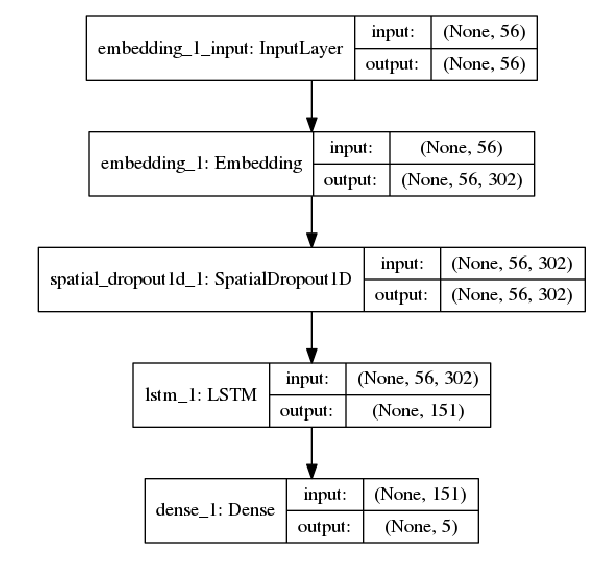

In [25]:
from keras.utils.vis_utils import plot_model

plot_model(dl_lstm_model, to_file='dl_lstm_model.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('dl_lstm_model.png')
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.grid(False)
imgplot = plt.imshow(img)

### Model Evaluation

31212/31212 [==============================] - 65s 2ms/step

              precision    recall  f1-score   support

           0       0.56      0.28      0.37      1414
           1       0.51      0.53      0.52      5455
           2       0.73      0.82      0.77     15917
           3       0.58      0.51      0.54      6585
           4       0.57      0.43      0.49      1841

   micro avg       0.65      0.65      0.65     31212
   macro avg       0.59      0.51      0.54     31212
weighted avg       0.64      0.65      0.64     31212


accuracy_score 0.6539151608355761

Weighted Averaged validation metrics
precision_score 0.6446901874536664
recall_score 0.6539151608355761
f1_score 0.6449771985303498

elapsed time: 381 seconds


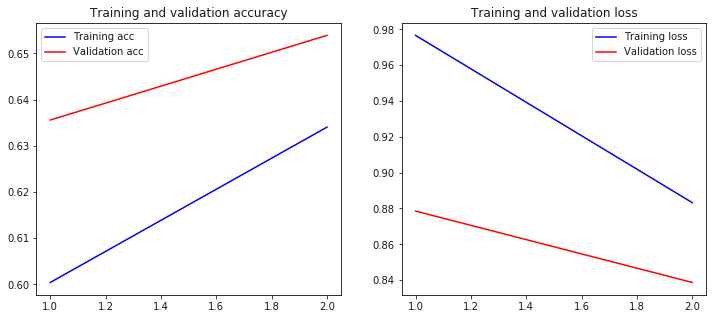

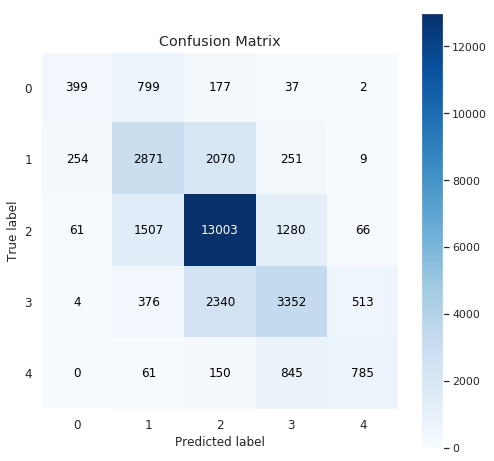

In [26]:
plot_history(history_lstm)

y_pred_lstm = dl_lstm_model.predict_classes(xvalid, verbose=1)
print()

print(classification_report(yvalid, y_pred_lstm))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_lstm))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_lstm, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_lstm, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_lstm, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_lstm)

dl_performance_metrics_df.loc['LSTM']['training-time'] = elapsed_time
dl_performance_metrics_df.loc['LSTM']['accuracy'] = accuracy_score(yvalid, y_pred_lstm)
dl_performance_metrics_df.loc['LSTM']['F1-score'] = f1_score(yvalid, y_pred_lstm, average='weighted')

print("elapsed time:", round(elapsed_time), "seconds")

### Deep Learning Model - Bidirectional Long Short Term Memory networks (BiLSTM)

A major issue with all of the Recurrent networks is that they learn representations from previous time steps. Sometimes, you might have to learn representations from future time steps to better understand the context and eliminate ambiguity. Take the following examples, “He said, Teddy bears are on sale” and “He said, Teddy Roosevelt was a great President”. In the above two sentences, when we are looking at the word “Teddy” and the previous two words “He said”, we might not be able to understand if the sentence refers to the President or Teddy bears. Therefore, to resolve this ambiguity, we need to look ahead. This is what Bidirectional RNNs accomplish. The repeating module in a Bidirectional RNN could be a conventional RNN, LSTM or GRU. [source](https://towardsdatascience.com/introduction-to-sequence-models-rnn-bidirectional-rnn-lstm-gru-73927ec9df15).

The following function builds a Deep Learning sequential network with the following stracture:

- The Embedding Layers where word embeddings are trained which reduces the one-hot-encoding phrases vectors to a dense with size of 300
- A dropout Layers where with regularize the connection between the embedding layer and the following Bidirectional LSTM layer
- Then the Bidirectional LSTM layer with number of cells equal to 150
- A dropout Layers where with regularize the connection between the the LSTM layer and the following 5 dense neurons
- Finally the last layer is 5 neurons equal to the number of sentiment classes

As optimizer we use the *nadam* and the fitting goal is to maximize the model's accuracy, hence we use a checkpointer Keras function for that to save the best model. Furthemore, the earlyStopping function will be utlized to avoid overfitting

As the loss / coss function since we have categorical variables to be predicted we used the categorical_crossentropy loss function.

In every epoch the DL model will be evaluated in the validation set. If the accuracy improves in the new epoch the model will be saved. But after 3 iterations of no improvement the model the fitting will be stopped.

For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.

In [27]:
def build_dl_bidirectional_lstm_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs, filename):

    ## Network architecture
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import EarlyStopping
    from keras.optimizers import RMSprop, SGD, adam
    from keras.layers import Masking
    from keras.initializers import Constant
    import time
    
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    start_time = time.time()
    
    
    from numpy.random import seed
    seed(42)
    from tensorflow import set_random_seed
    set_random_seed(42)


    embedding_size= embedding_dim + 2
    batch_size = 256
    dropouts = 0.2
    epochs = num_of_epochs
    
    model=Sequential()
    model.add(Embedding(input_dim = vocabulary_size, output_dim = embedding_size, input_length=max_len, 
                        weights=[embedding_matrix], trainable = False, mask_zero=True))
    
    model.add(SpatialDropout1D(dropouts))
    
    model.add(Bidirectional(LSTM(int(embedding_size/2), recurrent_dropout=dropouts, dropout=dropouts, return_sequences=False)))
    
    model.add(Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['categorical_accuracy']) # RMSprop

    '''
    saves the model weights after each epoch if the val_acc loss decreased
    '''
    checkpointer = ModelCheckpoint(monitor='val_categorical_accuracy', mode='max', filepath=''+filename+'.hdf5', verbose=2, save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='max')

    history = model.fit(x = xtrain, y = to_categorical(ytrain), validation_data=(xvalid, to_categorical(yvalid)), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

    model = load_model(''+filename+'.hdf5')
    
    elapsed_time = time.time() - start_time
    
    return model, history, elapsed_time


In [28]:

dl_bidirectional_lstm_model, history_bidirectional_lstm, elapsed_time = build_dl_bidirectional_lstm_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs=50, filename="bidirectional_lstm")
print("Elapsed time in seconds:", elapsed_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 56, 302)           5883564   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 56, 302)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 302)               548432    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1515      
Total params: 6,433,511
Trainable params: 549,947
Non-trainable params: 5,883,564
_________________________________________________________________
None
Train on 124848 samples, validate on 31212 samples
Epoch 1/2
 - 178s - loss: 0.9865 - categorical_accuracy: 0.5968 - val_loss: 0.8836 - val_categorical_accuracy: 0.6350

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63504, saving model t

### Model Summary

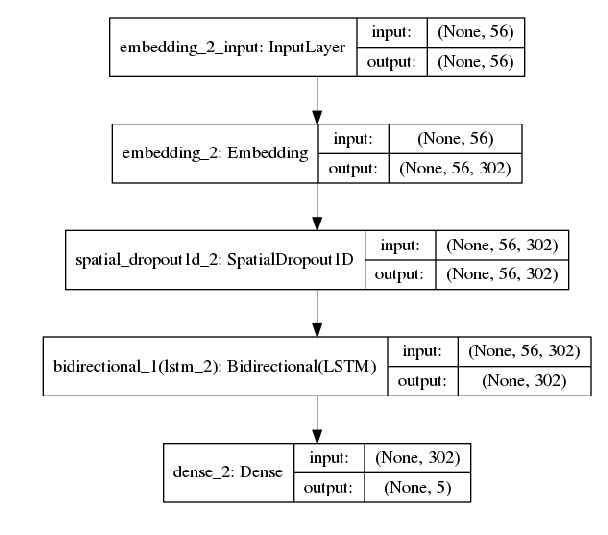

In [29]:
from keras.utils.vis_utils import plot_model

plot_model(dl_bidirectional_lstm_model, to_file='dl_bidirectional_lstm_model.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('dl_bidirectional_lstm_model.png')
plt.rcParams["figure.figsize"] = (10,10)
plt.axis('off')
plt.grid(False)
imgplot = plt.imshow(img)

### Model Evaluation

31212/31212 [==============================] - 122s 4ms/step

              precision    recall  f1-score   support

           0       0.59      0.24      0.34      1414
           1       0.52      0.51      0.52      5455
           2       0.73      0.82      0.77     15917
           3       0.57      0.53      0.55      6585
           4       0.60      0.36      0.45      1841

   micro avg       0.65      0.65      0.65     31212
   macro avg       0.60      0.49      0.53     31212
weighted avg       0.64      0.65      0.64     31212


accuracy_score 0.6535306933230809

Weighted Averaged validation metrics
precision_score 0.64393391603638
recall_score 0.6535306933230809
f1_score 0.641925795308742

elapsed time: 363 seconds


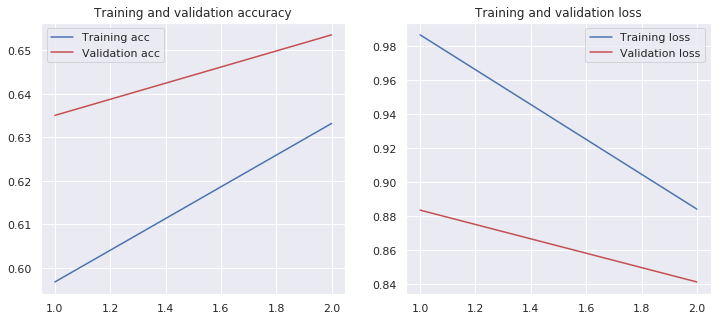

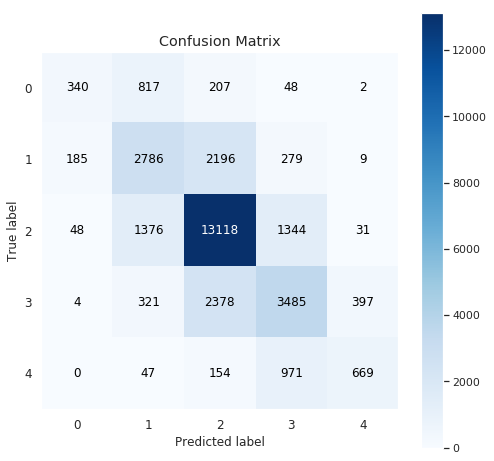

In [30]:
plot_history(history_bidirectional_lstm)

y_pred_bidirectional_lstm = dl_bidirectional_lstm_model.predict_classes(xvalid, verbose=1)
print()

print(classification_report(yvalid, y_pred_bidirectional_lstm))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_bidirectional_lstm))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_bidirectional_lstm, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_bidirectional_lstm, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_bidirectional_lstm, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_bidirectional_lstm)


dl_performance_metrics_df.loc['BiLSTM']['training-time'] = elapsed_time
dl_performance_metrics_df.loc['BiLSTM']['accuracy'] = accuracy_score(yvalid, y_pred_bidirectional_lstm)
dl_performance_metrics_df.loc['BiLSTM']['F1-score'] = f1_score(yvalid, y_pred_bidirectional_lstm, average='weighted')

print("elapsed time:", round(elapsed_time), "seconds")

### Deep Learning Models - Convolutional Neural Networks

Convolutional Neural Networks are very famous for applications in image classification. The whole idea about ConvNets stems from the notion that by adding more and more layers to the network the DL model can understand more and more features from an image and categotize it easier and more efficiently [source](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/). Moreover, the same architecture presents great results with Text classification problems [source](http://www.joshuakim.io/understanding-how-convolutional-neural-network-cnn-perform-text-classification-with-word-embeddings/).

The following function builds a Deep Learning sequential network with the following stracture:

- The Embedding Layers where word embeddings are trained which reduces the one-hot-encoding phrases vectors to a dense with size of 300
- A dropout Layers where with regularize the connection between the embedding layer and the following ConvNets layer
- 3 fully connected Convolutional Layers, each time the number of units are increasing and the same happens to the kernel_size / filter
- A GlobalMaxPooling to pool the best features from the ConvNets
- They the best features are fed to a fully connected Dense neural units equal to 150 neurons
- A dropout Layers where with regularize the connection between the the LSTM layer and the following 5 dense neurons
- Finally the last layer is 5 neurons equal to the number of sentiment classes

As optimizer we use the *nadam* and the fitting goal is to maximize the model's accuracy, hence we use a checkpointer Keras function for that to save the best model. Furthemore, the earlyStopping function will be utlized to avoid overfitting

As the loss / coss function since we have categorical variables to be predicted we used the categorical_crossentropy loss function.

In every epoch the DL model will be evaluated in the validation set. If the accuracy improves in the new epoch the model will be saved. But after 3 iterations of no improvement the model the fitting will be stopped.

For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.

In [31]:
def build_dl_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs, filename):

    ## Network architecture
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import EarlyStopping
    from keras.optimizers import RMSprop, SGD, adam
    from keras.layers import Masking
    from keras.initializers import Constant
    import time
    
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    start_time = time.time()
    
    
    from numpy.random import seed
    seed(42)
    from tensorflow import set_random_seed
    set_random_seed(42)

    embedding_size= embedding_dim + 2
    batch_size = 128
    dropouts = 0.2
    epochs = num_of_epochs
    
    model=Sequential()
    model.add(Embedding(input_dim = vocabulary_size, output_dim = embedding_size, input_length=max_len, 
                        weights=[embedding_matrix], trainable = False))
    
    model.add(SpatialDropout1D(dropouts))
        
    model.add(Conv1D(128, kernel_size = 1, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(256, kernel_size = 3, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(512, kernel_size = 5, strides = 1,  padding='valid', activation='relu'))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropouts))

    model.add(Dense(int(embedding_size/2), activation="relu"))
    model.add(Dropout(dropouts))
    
    model.add(Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['categorical_accuracy'])

    '''
    saves the model weights after each epoch if the val_acc loss decreased
    '''
    checkpointer = ModelCheckpoint(monitor='val_categorical_accuracy', mode='max', filepath=''+filename+'.hdf5', verbose=2, save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='max')

    history = model.fit(x = xtrain, y = to_categorical(ytrain), validation_data=(xvalid, to_categorical(yvalid)), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

    model = load_model(''+filename+'.hdf5')
    
    elapsed_time = time.time() - start_time
    
    return model, history, elapsed_time


In [32]:

dl_cnn_model, history_cnn, elapsed_time = build_dl_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs=30, filename="cnn")
print("Elapsed time in seconds:", elapsed_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 56, 302)           5883564   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 56, 302)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 128)           38784     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 54, 256)           98560     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 512)           655872    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

### Model Summary

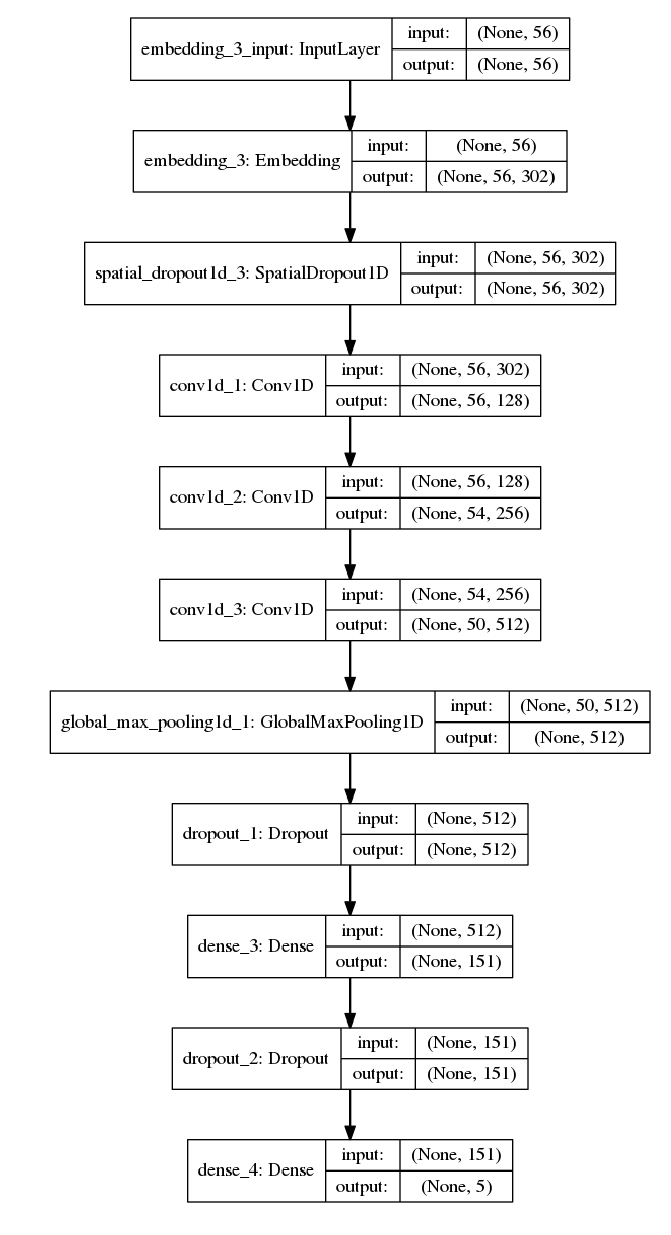

In [33]:
from keras.utils.vis_utils import plot_model

plot_model(dl_cnn_model, to_file='dl_cnn_model.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('dl_cnn_model.png')
plt.rcParams["figure.figsize"] = (21,22)
plt.axis('off')
plt.grid(False)
imgplot = plt.imshow(img)

### Model Evaluation

31212/31212 [==============================] - 4s 124us/step

              precision    recall  f1-score   support

           0       0.72      0.03      0.06      1414
           1       0.53      0.37      0.44      5455
           2       0.68      0.88      0.77     15917
           3       0.57      0.57      0.57      6585
           4       0.72      0.13      0.22      1841

   micro avg       0.64      0.64      0.64     31212
   macro avg       0.64      0.39      0.41     31212
weighted avg       0.64      0.64      0.60     31212


accuracy_score 0.6411316160451108

Weighted Averaged validation metrics
precision_score 0.6363612497505139
recall_score 0.6411316160451108
f1_score 0.6034336485186764

elapsed time: 63 seconds


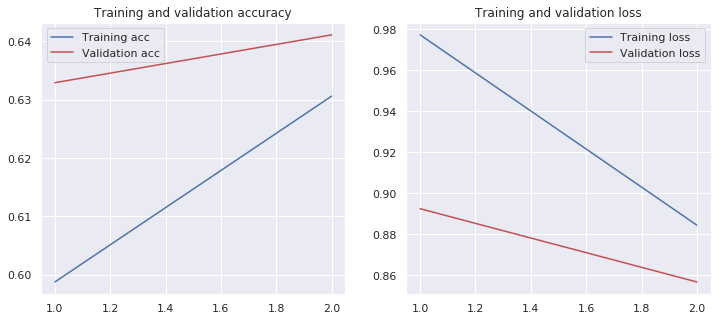

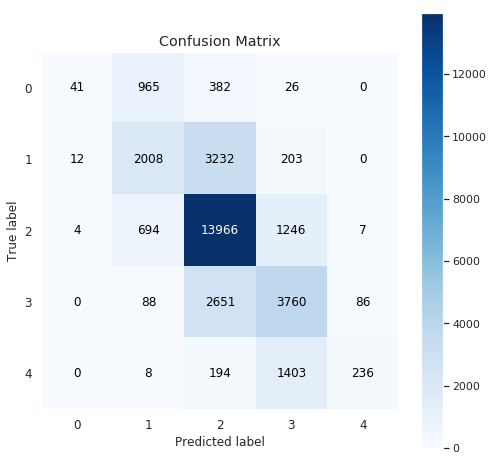

In [34]:
plot_history(history_cnn)

y_pred_cnn = dl_cnn_model.predict_classes(xvalid, verbose=1)
print()

print(classification_report(yvalid, y_pred_cnn))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_cnn))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_cnn, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_cnn, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_cnn, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_cnn)


dl_performance_metrics_df.loc['CNN']['training-time'] = elapsed_time
dl_performance_metrics_df.loc['CNN']['accuracy'] = accuracy_score(yvalid, y_pred_cnn)
dl_performance_metrics_df.loc['CNN']['F1-score'] = f1_score(yvalid, y_pred_cnn, average='weighted')

print("elapsed time:", round(elapsed_time), "seconds")

### Deep Learning Model: Combining LSTM and CNN together (LSTM_CNN)
There are papers in the scientific literature that combine both LSTM and CNN to improve the DL models performance by deepening the network [source](https://arxiv.org/abs/1511.08630). Thus the same will be done and here!

The following function builds a Deep Learning sequential network with the following stracture:

- The Embedding Layers where word embeddings are trained which reduces the one-hot-encoding phrases vectors to a dense with size of 300
- A dropout Layers where with regularize the connection between the embedding layer and the following LSTM layer
- The LSTM layer with 150 units
- 3 fully connected Convolutional Layers, each time the number of units are increasing and the same happens to the kernel_size / filter
- A GlobalMaxPooling to pool the best features from the ConvNets
- They the best features are fed to a fully connected Dense neural units equal to 150 neurons
- A dropout Layers where with regularize the connection between the the LSTM layer and the following 5 dense neurons
- Finally the last layer is 5 neurons equal to the number of sentiment classes

As optimizer we use the *nadam* and the fitting goal is to maximize the model's accuracy, hence we use a checkpointer Keras function for that to save the best model. Furthemore, the earlyStopping function will be utlized to avoid overfitting

As the loss / coss function since we have categorical variables to be predicted we used the categorical_crossentropy loss function.

In every epoch the DL model will be evaluated in the validation set. If the accuracy improves in the new epoch the model will be saved. But after 3 iterations of no improvement the model the fitting will be stopped.

For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.



In [35]:
def build_dl_lstm_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs, filename):

    ## Network architecture
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import EarlyStopping
    from keras.optimizers import RMSprop, SGD, adam
    from keras.layers import Masking
    from keras.initializers import Constant
    import time
    
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    start_time = time.time()
    
    
    from numpy.random import seed
    seed(42)
    from tensorflow import set_random_seed
    set_random_seed(42)


    embedding_size= embedding_dim + 2 #128
    batch_size = 128
    dropouts = 0.2
    epochs = num_of_epochs
    
    model=Sequential()
    model.add(Embedding(input_dim = vocabulary_size, output_dim = embedding_size, input_length=max_len, 
                        weights=[embedding_matrix], trainable = False))
    
    model.add(SpatialDropout1D(dropouts))
    
    model.add(LSTM(int(embedding_size/2), recurrent_dropout=dropouts, dropout=dropouts, 
                   return_sequences=True))
    
    model.add(Conv1D(128, kernel_size = 1, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(256, kernel_size = 3, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(512, kernel_size = 5, strides = 1,  padding='valid', activation='relu'))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropouts))

    model.add(Dense(int(embedding_size/2), activation="relu"))
    model.add(Dropout(dropouts))
    
    model.add(Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['categorical_accuracy']) # RMSprop

    '''
    saves the model weights after each epoch if the val_acc loss decreased
    '''
    checkpointer = ModelCheckpoint(monitor='val_categorical_accuracy', mode='max', filepath=''+filename+'.hdf5', verbose=2, save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='max')

    history = model.fit(x = xtrain, y = to_categorical(ytrain), validation_data=(xvalid, to_categorical(yvalid)), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

    model = load_model(''+filename+'.hdf5')
    
    elapsed_time = time.time() - start_time
    
    return model, history, elapsed_time


In [36]:

dl_lstm_cnn_model, history_lstm_cnn, elapsed_time = build_dl_lstm_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs=30, filename="lstm_cnn")
print("Elapsed time in seconds:", elapsed_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 56, 302)           5883564   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 56, 302)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 56, 151)           274216    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 56, 128)           19456     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 54, 256)           98560     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 512)           655872    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
__________

### Model Summary

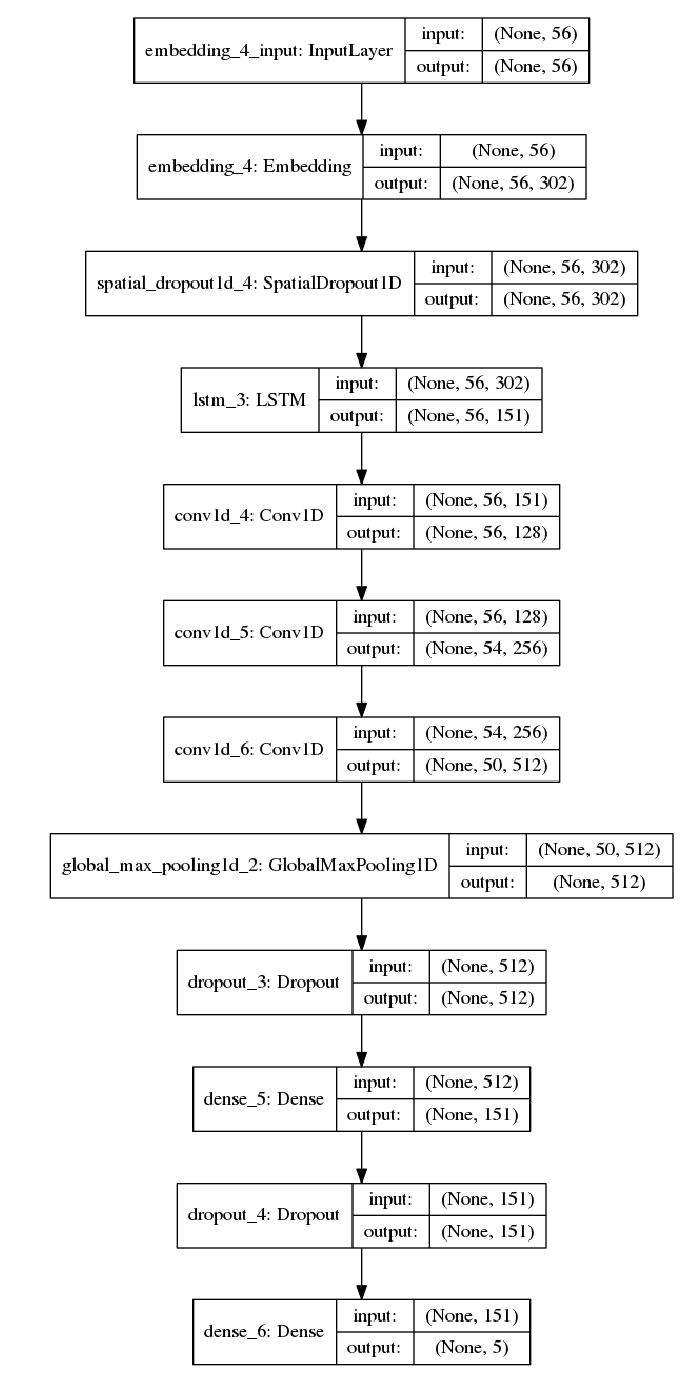

In [37]:
from keras.utils.vis_utils import plot_model

plot_model(dl_lstm_cnn_model, to_file='dl_lstm_cnn_model.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('dl_lstm_cnn_model.png')
plt.rcParams["figure.figsize"] = (20,25)
plt.axis('off')
plt.grid(False)
imgplot = plt.imshow(img)

### Model Evaluation

31212/31212 [==============================] - 58s 2ms/step

              precision    recall  f1-score   support

           0       0.52      0.31      0.39      1414
           1       0.51      0.57      0.54      5455
           2       0.73      0.81      0.77     15917
           3       0.60      0.51      0.55      6585
           4       0.62      0.32      0.42      1841

   micro avg       0.66      0.66      0.66     31212
   macro avg       0.60      0.51      0.53     31212
weighted avg       0.65      0.66      0.65     31212


accuracy_score 0.6554209919261822

Weighted Averaged validation metrics
precision_score 0.6490378702985018
recall_score 0.6554209919261822
f1_score 0.6462737921777101

elapsed time: 303 seconds


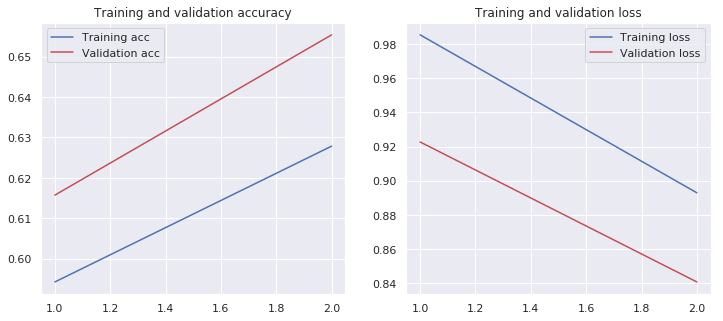

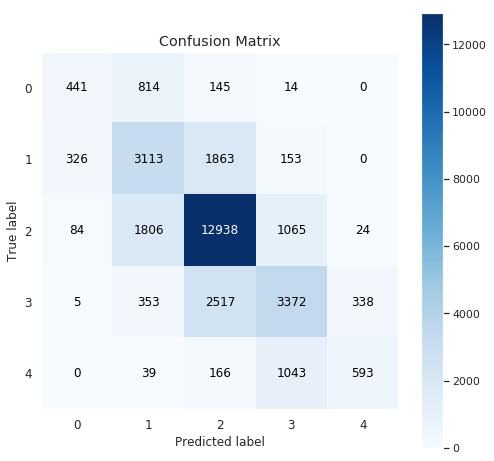

In [38]:
plot_history(history_lstm_cnn)

y_pred_lstm_cnn = dl_lstm_cnn_model.predict_classes(xvalid, verbose=1)
print()

print(classification_report(yvalid, y_pred_lstm_cnn))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_lstm_cnn))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_lstm_cnn, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_lstm_cnn, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_lstm_cnn, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_lstm_cnn)


dl_performance_metrics_df.loc['LSTM_CNN']['training-time'] = elapsed_time
dl_performance_metrics_df.loc['LSTM_CNN']['accuracy'] = accuracy_score(yvalid, y_pred_lstm_cnn)
dl_performance_metrics_df.loc['LSTM_CNN']['F1-score'] = f1_score(yvalid, y_pred_lstm_cnn, average='weighted')

print("elapsed time:", round(elapsed_time), "seconds")

### Deep Learning Model: Combining Bidirectional LSTM and CNN together (BiLSTM_CNN)
Following the precious model lets took the liberty to combine and a bidirectional LSTM and a CNN together!

The following function builds a Deep Learning sequential network with the following stracture:

- The Embedding Layers where word embeddings are trained which reduces the one-hot-encoding phrases vectors to a dense with size of 300
- A dropout Layers where with regularize the connection between the embedding layer and the following Bidirectional LSTM layer
- The Bidirectional LSTM layer with 150 units
- 3 fully connected Convolutional Layers, each time the number of units are increasing and the same happens to the kernel_size / filter
- A GlobalMaxPooling to pool the best features from the ConvNets
- They the best features are fed to a fully connected Dense neural units equal to 150 neurons
- A dropout Layers where with regularize the connection between the the LSTM layer and the following 5 dense neurons
- Finally the last layer is 5 neurons equal to the number of sentiment classes

As optimizer we use the *nadam* and the fitting goal is to maximize the model's accuracy, hence we use a checkpointer Keras function for that to save the best model. Furthemore, the earlyStopping function will be utlized to avoid overfitting

As the loss / coss function since we have categorical variables to be predicted we used the categorical_crossentropy loss function.

In every epoch the DL model will be evaluated in the validation set. If the accuracy improves in the new epoch the model will be saved. But after 3 iterations of no improvement the model the fitting will be stopped.

For all the DL models the random state will be set to 42 in order to the models be reproducable and create the same results in every run.

In [39]:
def build_dl_bidirectional_lstm_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs, filename):

    ## Network architecture
    from keras.utils import to_categorical
    from keras.callbacks import ModelCheckpoint
    from keras.callbacks import EarlyStopping
    from keras.optimizers import RMSprop, SGD, adam
    from keras.layers import Masking
    from keras.initializers import Constant
    import time
    
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    start_time = time.time()
    
    
    from numpy.random import seed
    seed(42)
    from tensorflow import set_random_seed
    set_random_seed(42)
    
    
    embedding_size = embedding_dim + 2
    batch_size = 256
    dropouts = 0.2
    epochs = num_of_epochs
    
    model=Sequential()
    model.add(Embedding(vocabulary_size, embedding_size, input_length=max_len, 
                        weights=[embedding_matrix], trainable = False))
    
    model.add(SpatialDropout1D(dropouts))
    
    model.add(Bidirectional(LSTM(int(embedding_size/2), recurrent_dropout=dropouts, dropout=dropouts, 
                   return_sequences=True)))
    
    model.add(Conv1D(128, kernel_size=2, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(256, kernel_size=3, strides = 1,  padding='valid', activation='relu'))
    model.add(Conv1D(512, kernel_size=5, strides = 1,  padding='valid', activation='relu'))
    
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(dropouts))
    
    model.add(Dense(int(embedding_size/2), activation="relu"))
    model.add(Dropout(dropouts))
    
    model.add(Dense(5, activation='softmax'))

    print(model.summary())

    model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics=['categorical_accuracy']) # RMSprop

    '''
    saves the model weights after each epoch if the val_acc loss decreased
    '''
    checkpointer = ModelCheckpoint(monitor='val_categorical_accuracy', mode='max', filepath=''+filename+'.hdf5', verbose=2, save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='max')

    history = model.fit(x = xtrain, y = to_categorical(ytrain), validation_data=(xvalid, to_categorical(yvalid)), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[checkpointer, earlyStopping])

    model = load_model(''+filename+'.hdf5')
    
    elapsed_time = time.time() - start_time
    
    return model, history, elapsed_time


In [40]:

dl_bidirectional_lstm_cnn_model, history_bidirectional_lstm_cnn, elapsed_time = build_dl_bidirectional_lstm_cnn_model(xtrain, ytrain, xvalid, yvalid, num_of_epochs=50, filename="bidirectional_lstm_cnn")
print("Elapsed time in seconds:", elapsed_time)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 56, 302)           5883564   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 56, 302)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 56, 302)           548432    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 55, 128)           77440     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 53, 256)           98560     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 49, 512)           655872    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
__________

### Model Summary

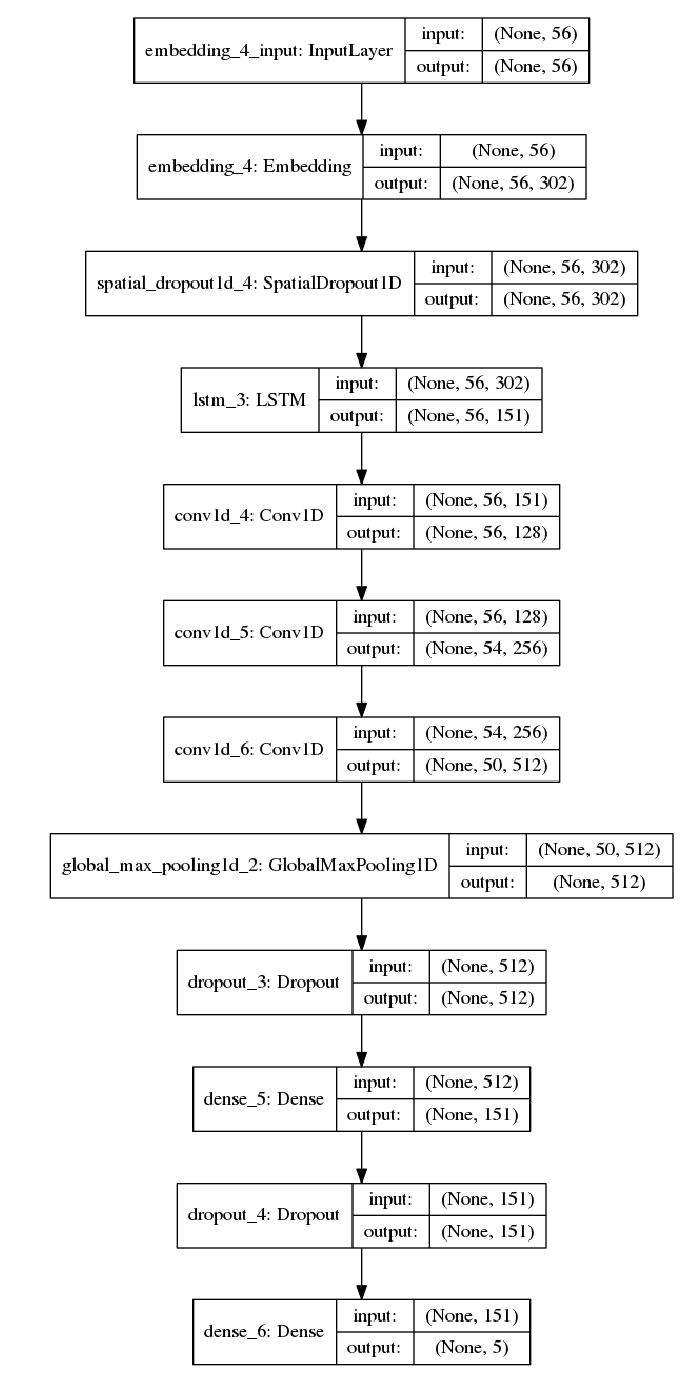

In [41]:
from keras.utils.vis_utils import plot_model

plot_model(dl_bidirectional_lstm_cnn_model, to_file='dl_bidirectional_lstm_cnn_model.png', show_shapes=True, show_layer_names=True)

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('dl_lstm_cnn_model.png')
plt.rcParams["figure.figsize"] = (20,25)
plt.axis('off')
plt.grid(False)
imgplot = plt.imshow(img)

### Model Evaluation

31212/31212 [==============================] - 106s 3ms/step

              precision    recall  f1-score   support

           0       0.62      0.18      0.28      1414
           1       0.51      0.57      0.54      5455
           2       0.75      0.78      0.76     15917
           3       0.56      0.61      0.58      6585
           4       0.67      0.24      0.35      1841

   micro avg       0.65      0.65      0.65     31212
   macro avg       0.62      0.48      0.50     31212
weighted avg       0.65      0.65      0.64     31212


accuracy_score 0.6514161220043573

Weighted Averaged validation metrics
precision_score 0.6537570952007656
recall_score 0.6514161220043573
f1_score 0.6404434221796653

elapsed time: 324 seconds


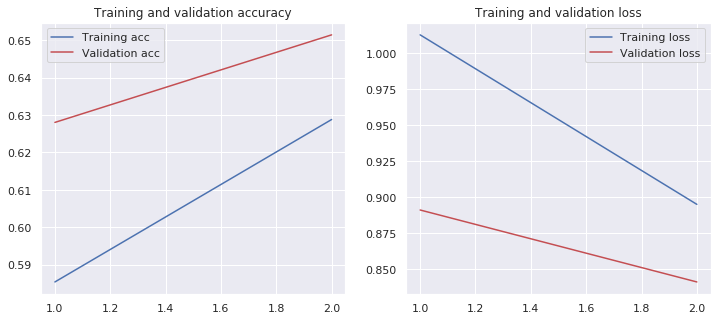

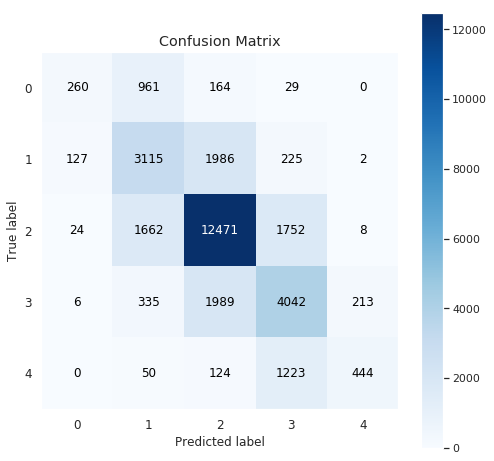

In [42]:
plot_history(history_bidirectional_lstm_cnn)

y_pred_bidirectional_lstm_cnn = dl_bidirectional_lstm_cnn_model.predict_classes(xvalid, verbose=1)
print()

print(classification_report(yvalid, y_pred_bidirectional_lstm_cnn))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_bidirectional_lstm_cnn))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_bidirectional_lstm_cnn, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_bidirectional_lstm_cnn, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_bidirectional_lstm_cnn, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_bidirectional_lstm_cnn)


dl_performance_metrics_df.loc['BiLSTM_CNN']['training-time'] = elapsed_time
dl_performance_metrics_df.loc['BiLSTM_CNN']['accuracy'] = accuracy_score(yvalid, y_pred_bidirectional_lstm_cnn)
dl_performance_metrics_df.loc['BiLSTM_CNN']['F1-score'] = f1_score(yvalid, y_pred_bidirectional_lstm_cnn, average='weighted')

print("elapsed time:", round(elapsed_time), "seconds")

### Summarizing DL Models based on their accuracy with Trainable Word Embeddings as Feature Extraction / Representation

In [ ]:
dl_performance_metrics_df.sort_values(by="accuracy", ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
dl_performance_metrics_df.sort_values(by="accuracy", ascending=False).accuracy.plot(kind="bar")

### Summarizing DL Models based on their F1-score with Trainable Word Embeddings as Feature Extraction / Representation

In [ ]:
dl_performance_metrics_df.sort_values(by="F1-score", ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
dl_performance_metrics_df.sort_values(by="F1-score", ascending=False)["F1-score"].plot(kind="bar")

### Summarizing DL Models based on their training time with Trainable Word Embeddings as Feature Extraction / Representation

In [ ]:
dl_performance_metrics_df.sort_values(by="training-time", ascending=False)

In [ ]:
sns.set(rc={'figure.figsize':(15.27,6.27)})
dl_performance_metrics_df.sort_values(by="training-time", ascending=False)["training-time"].plot(kind="bar")

### Ensemble Models
Ensemble DL Models using the statistical mode for the predicted classed over the validation set.

In [ ]:
y_pred_lstm = dl_lstm_model.predict_classes(xvalid, verbose=1)

y_pred_cnn = dl_cnn_model.predict_classes(xvalid, verbose=1)

y_pred_bidirectional_lstm = dl_bidirectional_lstm_model.predict_classes(xvalid, verbose=1)

y_pred_lstm_cnn = dl_lstm_cnn_model.predict_classes(xvalid, verbose=1)

y_pred_bidirectional_lstm_cnn =  dl_bidirectional_lstm_cnn_model.predict_classes(xvalid, verbose=1)


### Model Evaluation

In [ ]:
ensemble_all_dl_pred_df = pd.DataFrame({'model_lstm':y_pred_lstm,
                                                'model_bidirectional_lstm':y_pred_bidirectional_lstm,
                                                'model_cnn':y_pred_cnn,
                                                'model_bidirectional_lstm_cnn':y_pred_bidirectional_lstm_cnn,
                                                'model_lstm_cnn':y_pred_lstm_cnn,
                                                })


pred_mode = ensemble_all_dl_pred_df.agg('mode',axis=1)[0].values

print()
print(classification_report(yvalid, pred_mode))

print()
print("accuracy_score", accuracy_score(yvalid, pred_mode))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, pred_mode, average='weighted'))
print("recall_score", recall_score(yvalid, pred_mode, average='weighted'))
print("f1_score", f1_score(yvalid, pred_mode, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, pred_mode)


### Making Predictions and preparing the submissions' csv files

In [ ]:
xtest = tokenizer.texts_to_sequences(df_test.Phrase.values)
xtest = pad_sequences(xtest, maxlen=max_len)

y_pred_test_lstm = dl_lstm_model.predict_classes(xtest, verbose=1)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = y_pred_test_lstm
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_lstm.csv',index=False)


y_pred_test_bidirectional_lstm = dl_bidirectional_lstm_model.predict_classes(xtest, verbose=1)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = y_pred_test_bidirectional_lstm
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_bidirectional_lstm.csv',index=False)


y_pred_test_cnn = dl_cnn_model.predict_classes(xtest, verbose=1)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = y_pred_test_cnn
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_cnn.csv',index=False)


y_pred_test_lstm_cnn = dl_lstm_cnn_model.predict_classes(xtest, verbose=1)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = y_pred_test_lstm_cnn
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_lstm_cnn.csv',index=False)


y_pred_test_bidirectional_lstm_cnn = dl_bidirectional_lstm_cnn_model.predict_classes(xtest, verbose=1)
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = y_pred_test_bidirectional_lstm_cnn
#submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_bidirectional_lstm_cnn.csv',index=False)

### Ensebling Predictions over the test set

In [ ]:
ensemble_all_dl_pred_test_df = pd.DataFrame({'model_lstm':y_pred_test_lstm,
                                                'model_bidirectional_lstm':y_pred_test_bidirectional_lstm,
                                                'model_cnn':y_pred_test_cnn,
                                                'model_lstm_cnn':y_pred_test_lstm_cnn,
                                                'model_bidirectional_lstm_cnn':y_pred_test_bidirectional_lstm_cnn})


pred_test_mode = ensemble_all_dl_pred_test_df.agg('mode',axis=1)[0].values
submission = pd.DataFrame()
submission['PhraseId'] = df_test.PhraseId
submission['Sentiment'] = pred_test_mode
submission['Sentiment'] = submission.Sentiment.astype(int)
submission.to_csv('submission_ensemble.csv',index=False)


## Summary



__________________________